# Using Pandas dataframes
This example demonstrate more comprehensive feauture usage of the library:

* Read data from an open dataset into a Pandas dataframe object
* Split into test- and training data set
* Z-score normalization of the training set
* Train a gradient VAR model in batches, with time weighting of the batches
* Make a forecast and a lagged forecast

Be sure to install the following packages to run this example:

```sh
!pip install matplotlib pandas numpy kagglehub
```

In [1]:
import pandas as pd
import numpy as np
import kagglehub
from gradvar.gradvar import GradVAR
from gradvar.earlystopping import EarlyStopping
import matplotlib.pyplot as plt

## Read example data

We use an open Kaggle dataset for the examples in this project. Specifically, we utilize the [Delhi 5-Minute Electricity Demand for Forecasting dataset](https://www.kaggle.com/datasets/yug201/delhi-5-minute-electricity-demand-for-forecasting), which provides high-frequency electricity demand data for Delhi. This dataset is ideal for demonstrating time series analysis, forecasting techniques, and anomaly detection.

In [2]:
path = kagglehub.dataset_download("yug201/delhi-5-minute-electricity-demand-for-forecasting")
data = pd.read_csv(path + "/powerdemand_5min_2021_to_2024_with weather.csv")

In [3]:
data.head()

,Unnamed: 0,datetime,Power demand,temp,dwpt,rhum,wdir,wspd,pres,year,month,day,hour,minute,moving_avg_3
0,0,2021-01-01 00:30:00,2014.00,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,30,NaN
1,1,2021-01-01 00:35:00,2005.63,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,35,NaN
2,2,2021-01-01 00:40:00,1977.60,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,40,1999.076667
3,3,2021-01-01 00:45:00,1976.44,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,45,1986.556667
4,4,2021-01-01 00:50:00,1954.37,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,50,1969.470000


The dataset consists of the following columns:

* datetime: Timestamp of the observation
* Power demand: Electricity demand (in kW) recorded every 5 minutes.
* temp: Temperature (°C).
* dwpt: Dew point temperature (°C).
* rhum: Relative humidity (%).
* wdir: Wind direction (degrees).
* wspd: Wind speed (m/s).
* pres: Atmospheric pressure (hPa).
* year, month, day, hour, minute: Breakdown of the timestamp for easy time-series analysis.

Evaluate the dataset and do necessary changes to its structure: we want a datetime column to be its index. Lets convert the `datetime` column, set it as index, and remove some of the fields:

In [4]:
data.datetime = pd.to_datetime(data['datetime'])
data = data.set_index("datetime", drop=True)
data = data.drop(columns=["Unnamed: 0", "minute"])
data.shape

(393440, 12)

We see that the dataset contains about 400k rows, lets downsample the data to 1 hour samples and define a feature vector:

In [5]:
features = ['Power demand', 'temp', 'wspd', 'dwpt']
interval = '1h'
downsampled_data = data.resample(interval).mean().dropna()
downsampled_data.shape

(33062, 12)

## Split into test- and training data set

We split the datasets into two parts, one for training and one for testing. We split by year, but a block-splitting/percentage based splitting could also be used. However, keep in mind that we need to keep the time series properties of the datasets, so we must not randomize the samples:

In [6]:
df_train = downsampled_data[downsampled_data.year <= 2023]
df_test = downsampled_data[downsampled_data.year == 2024]

## Z-score normalization

Z-score normalization is essential to prevent exploding gradients across different features, ensuring stable and successful training. We use the formula

$$X' = \frac{X - \mu}{\sigma}$$

where:

* $X'$ is the normalized value,
* $X$ is the original feature value,
* $\mu$ is the mean of the feature,
* $\sigma$ is the standard deviation of the feature.

This ensures that features have a mean of 0 and a standard deviation of 1, improving numerical stability during training. We record the mean and standard deviation on the training set and transform both training and test set with these value:

In [ ]:
mu = df_train[features].mean()
sigma = df_train[features].std()
df_train[features] = (df_train[features] - mu) / sigma
df_test[features] = (df_test[features] - mu) / sigma

## Train a VAR model using gradient methods

We now train the model in batches, with time weighting of each batch. The idea is that the oldest data will have less influence on the end model, and because of this we train with a weight, where the latest year is given the most significance. Other weighting schemes can be applied.

This also demonstrates the possibility to update the training matrices by submitting the A and B matrices from the previous run, an as such we continue training with new data.

In [8]:
model = GradVAR()
batchid_field = "year"
lags = 24 # hours
batches = df_train[batchid_field].unique()

total_losses = []
for w, batch in enumerate(batches):
      Y = df_train[df_train[batchid_field] == batch][features].values
      losses, *_ = model.train(Y, lags, learning_rate=0.001, num_epochs=10000, early_stopping = EarlyStopping(patience=30, min_delta=1e-5), A=model.A, B=model.B, C=model.C, D=model.D, W=np.sqrt(w+1))
      total_losses = [*total_losses, *losses]

total_losses = np.array(total_losses)

  9%|▉         | 925/10000 [01:09<11:16, 13.40it/s]


We can now plot the loss curve and determine convergence; as we see the curve flattens and training terminates early for all batches. But we also see that the loss increased on batch 2, meaning that we adjusted more to the later data due to weighting:

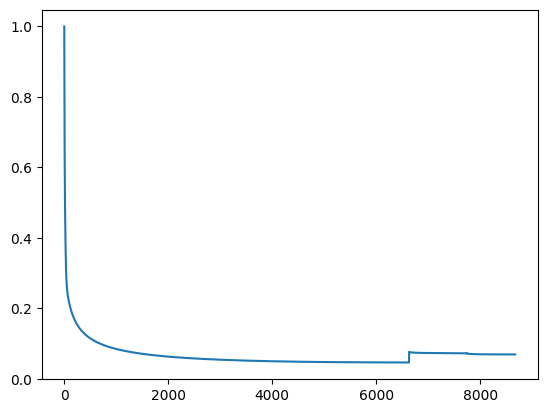

In [9]:
plt.plot(total_losses)
plt.show()

Lets investigate the $A$-coefficients for one lag in the model as well:

In [10]:
model.A[-1]

Array([[ 1.1974275 ,  0.00927226, -0.03920696, -0.00782728],
       [ 0.08996384,  1.4181781 ,  0.11386728, -0.01743492],
       [-0.01281363, -0.02468899,  1.2749718 , -0.00704564],
       [ 0.03009289,  0.00421482, -0.04604417,  1.275879  ]],      dtype=float32)

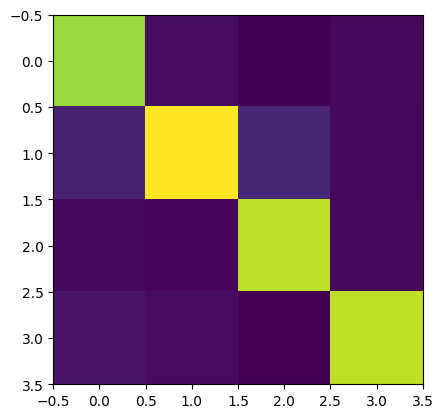

In [18]:
plt.imshow(model.A[-1])
plt.show()

## Forecasting with the model

First we make a traditional forecast and plot it:

In [12]:
horizon = 48 # hours
Y_test = df_test[features].values
Y_forecast = model.forecast(Y_test, horizon)
index = pd.date_range(start=df_test.index[-1] + pd.Timedelta(interval), periods=len(Y_forecast), freq=interval)
df_forecast = pd.DataFrame(Y_forecast, columns=features, index=index)

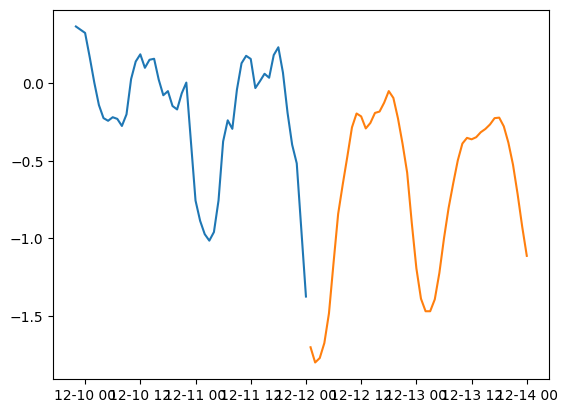

In [13]:
plt.plot(df_test["Power demand"].tail(48))
plt.plot(df_forecast["Power demand"])
plt.show()

Then, lets make a lagged forecast for a specific month in the test set:

In [14]:
df_subtest = df_test.loc["2024-06"]
Y_test = df_subtest[features].values
Y_forecast = model.lagged_forecast(Y_test, horizon)
df_forecast = pd.DataFrame(Y_forecast, columns=features, index=df_subtest.index)

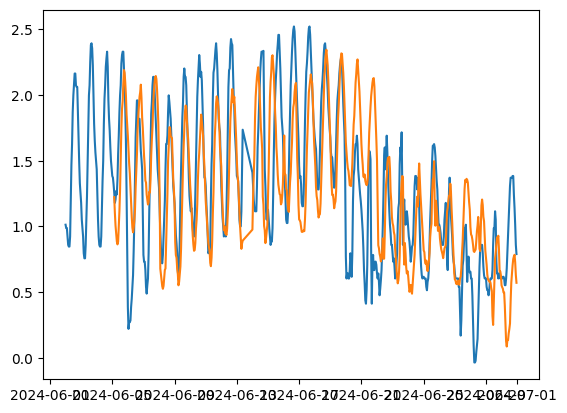

In [15]:
plt.plot(df_subtest["temp"])
plt.plot(df_forecast["temp"])
plt.show()

We could also calculate statistics for the forecasts for even better evaluation of the model.